# **УСТАНОВКА ОКРУЖЕНИЯ БИБЛИОТЕК И ПРОЧЕГО**

***(установите форк библиотеки, где поправлено несоответствие версий imgaug и numpy)***

In [1]:
# INSTALL FORK OF IMGAUG TO AVOID INCOMPATIBILITY WITH NUMPY (thanks marcown)
!pip install git+https://github.com/marcown/imgaug.git

  Cloning https://github.com/marcown/imgaug.git to /tmp/pip-req-build-1l35i144
  Running command git clone --filter=blob:none --quiet https://github.com/marcown/imgaug.git /tmp/pip-req-build-1l35i144
  Resolved https://github.com/marcown/imgaug.git to commit 5eb7adda6aa2ea1628e7e3a7d64d32a3335d38f5
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
from tqdm import tqdm

# Unix-style path matching (../../bruh/*/*.py)
from glob import glob
import os

# masks and all that kinda stuff
import cv2
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import zipfile
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, SpatialDropout2D, Dropout
from tensorflow.keras.losses import BinaryFocalCrossentropy

from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras import activations

from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import saving
import sklearn.utils as utils
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow import keras

2024-06-04 13:03:32.930762: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from time import sleep

In [4]:
!python -V

Python 3.11.0rc1


In [5]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPUs:", tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
tf.config.list_logical_devices()

2024-06-04 13:03:36.898922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22504 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:05:00.0, compute capability: 8.6


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [7]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
session = InteractiveSession(config=config)

2024-06-04 13:03:36.922706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22504 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:05:00.0, compute capability: 8.6


In [8]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [9]:
# If the path doesnt exist, we create a folder.
def create_dir(path: str):
    """
    Create folder if not exists.
    path (str): Path to a folder.
    """
    if not (os.path.exists(path)):
        os.mkdir(path)

# **ЗАГРУЗКА ДАТАСЕТА**

In [10]:
# import shutil
# shutil.rmtree(dataset)

In [11]:
path = 'archive.zip'

In [12]:
dataset = "people_segmentation"

In [13]:
# with zipfile.ZipFile(path, 'r') as zip_ref:
#     zip_ref.extractall(dataset)

In [14]:
dataset = os.path.join(dataset, "people_segmentation")

In [15]:
def load_data(path: str, train_proportion: float, random_state=42):
    """
    Split the data into train (input, ground truth) and test (input, ground_truth).
    path: str - Path to the dataset.
    train_proportion: Ratio of data for training (from 0 to 1).
    random_state=42: Random state to split train and test.
    """
    # Getting the paths to the images and to the masks.
    seg_data = sorted(glob(os.path.join(path, "images", "*.jpg")))
    # Masks are saved in .png format.
    seg_gt = sorted(glob(os.path.join(path, "masks", "*.png")))

    # Splitting the input into train and test sets
    train_input, test_input = train_test_split(seg_data, train_size=train_proportion, random_state=random_state)
    # Splitting the ground truth masks into train and test sets
    train_gt, test_gt = train_test_split(seg_gt, train_size=train_proportion, random_state=random_state)

    return (train_input, train_gt), (test_input, test_gt)

In [16]:
# Check if image corresponds to the mask if we use this way we load the data
print(
    sorted(glob(os.path.join(dataset, "masks", "*.png")))[0].split('/')[-1],
    sorted(glob(os.path.join(dataset, "images", "*.jpg")))[0].split('/')[-1]
    )

IMG_3496bfree.png IMG_3496bfree.jpg


In [17]:
# yes it does

In [18]:
images = np.array([cv2.imread(glob(os.path.join(dataset, "masks", "*.png"))[0], cv2.IMREAD_COLOR) for i in range(5)], dtype='uint8')
images.dtype

dtype('uint8')

# **АУГМЕНТАЦИЯ ДАННЫХ**

**для этого датасета значения ширины и высоты изображений (и соответствующих им масок) следующие: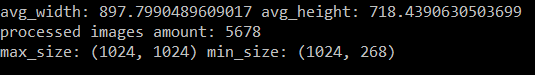**

In [19]:
def prep_and_augment(input: list, mask: list, save_path: str, H: int, W: int, augment=True, aug_count=5):
    """
    Modify the image dataset for segmentation task with augmentation.
    input: list - Input data.
    mask: list - Segmentation masks.
    save_path: str - Where to save images.
    augment=True - Whether to augment images or not.
    aug_count=5 - Number of augmented images.
    H, W - Size of the cropping window
    """

    # Defining augmentation pipeline.
    seq = None
    crop = iaa.Sequential([
            iaa.CropToFixedSize(
                height=H, width=W,
                position='normal'
                )
            ])
    if augment:
        seq = iaa.Sequential([
            iaa.CropToFixedSize(
                height=H, width=W,
                position='normal'
                ),
            iaa.Fliplr(0.5),
            iaa.SomeOf((0, 4), [
                    iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.9, 1.2)),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={
                            "x": (0.8, 1.2),
                            "y": (0.8, 1.2)
                        },
                        rotate=(-20, 20))
            ])
        ])
    else:
        seq = iaa.Sequential([
            iaa.CropToFixedSize(height=H, width=W)
        ])

    for i, m in tqdm(zip(input, mask), total=len(input)):
        # Extracting the name
        name = i.split('/')[-1].split('.')[0]

        # Reading images
        image = cv2.imread(i, cv2.IMREAD_COLOR)
        mask = cv2.imread(m, cv2.IMREAD_COLOR)

        mask = SegmentationMapsOnImage(mask, shape=mask.shape)
        for count in range(aug_count-1):
            image_aug, segmask_aug = seq(image=image, segmentation_maps=mask)
            segmask_aug = segmask_aug.get_arr()
            if (image_aug.shape[0] < H or image_aug.shape[1] < W):
                image_aug = cv2.resize(image_aug, (H, W), interpolation=cv2.INTER_LINEAR)
                segmask_aug = cv2.resize(segmask_aug, (H, W), interpolation=cv2.INTER_LINEAR)
            image_path = os.path.join(save_path, "images", f"{name}_aug{count}.jpg")
            segmask_path = os.path.join(save_path, "masks", f"{name}_aug{count}.png")
            cv2.imwrite(image_path, np.array(image_aug, dtype='uint8'))
            cv2.imwrite(segmask_path, np.array(segmask_aug, dtype='uint8'))
        
        image_crop, segmask_crop = crop(image=image, segmentation_maps=mask)
        segmask_crop = segmask_crop.get_arr()
        if (image_crop.shape[0] < H or image_crop.shape[1] < W):
            image_crop = cv2.resize(image_crop, (H, W), interpolation=cv2.INTER_LINEAR)
            segmask_crop = cv2.resize(segmask_crop, (H, W), interpolation=cv2.INTER_LINEAR)
        image_path = os.path.join(save_path, "images", f"{name}_crop.jpg")
        segmask_path = os.path.join(save_path, "masks", f"{name}_crop.png")
        cv2.imwrite(image_path, np.array(image_crop, dtype='uint8'))
        cv2.imwrite(segmask_path, np.array(segmask_crop, dtype='uint8'))

In [20]:
# Loading the dataset
train, test = load_data(dataset, 0.7)
train_input, train_gt = train
test_input, test_gt = test
name = test_input[0]
name = name.split('/')[-1].split('.')[0]
name

'pexels-photo-206396'

In [21]:
create_dir('dataset')
augmented_train = "dataset/augmented_train/"
augmented_test = "dataset/augmented_test/"

In [22]:
# # train_input, train_gt = load_data(dataset, 0.7)[0]
# create_dir(augmented_train)
# create_dir(os.path.join(augmented_train, "images"))
# create_dir(os.path.join(augmented_train, "masks"))
# create_dir(augmented_test)
# create_dir(os.path.join(augmented_test, "images"))
# create_dir(os.path.join(augmented_test, "masks"))
# prep_and_augment(train_input, train_gt, augmented_train, 512, 512, aug_count=3)
# prep_and_augment(test_input, test_gt, augmented_test, 512, 512, False, 1)

In [23]:
import matplotlib.pyplot as plt

In [24]:
def draw_masks(image_path, mask_path):

    # Load images as greyscale but make main RGB so we can annotate in colour
    seg  = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    main = cv2.imread(image_path,cv2.IMREAD_COLOR)

    print(main.shape)
    main[:, :, 0] *= seg[:, :]
    main[:, :, 2] *= seg[:, :]

    # Save result
    plt.imshow(main)

(512, 512, 3)


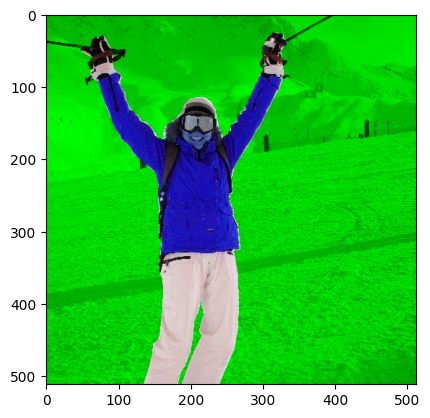

In [25]:
# это я на фотке
draw_masks(sorted(glob(os.path.join(augmented_train, "images", "*.jpg")))[16], sorted(glob(os.path.join(augmented_train, "masks", "*.png")))[16])

# **НАПИСАНИЕ МОДЕЛИ DEEPLABV3**
для encoder-модели была использована предварительно натренированная
на датасете ImageNet модель ResNet50

In [26]:
def deeplabv3_plus(shape):
    """
    Atrous convolution block (backbone of DeepLabv3).
    shape: Shape of the input tensor coming to ResNet50.
    """
    # Input
    inputs = Input(shape)

    # Encoder
    encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    image_features = encoder.get_layer("conv4_block6_out").output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = encoder.get_layer("conv2_block2_out").output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = SpatialDropout2D(0.2)(x_b) 
    x_b = BatchNormalization()(x_b)
    x_b = Activation(activations.leaky_relu)(x_b)

    x = Concatenate()([x_a, x_b])
    x = SqueezeAndExcite(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = SpatialDropout2D(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation(activations.leaky_relu)(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = SpatialDropout2D(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation(activations.leaky_relu)(x)
    x = SqueezeAndExcite(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(1, 1)(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [27]:
def SqueezeAndExcite(inputs, ratio=8):
    """
    Concurrent Squeeze and Excitation block to extract important features https://arxiv.org/pdf/1803.02579
    inputs - Tensor of feature maps from another layer.
    ratio=8 - Squeezing factor.
    """
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    # Channel squeeze SE
    cse = GlobalAveragePooling2D()(init)
    cse = Reshape(se_shape)(cse)
    cse = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(cse)
    cse = Dropout(0.2)(cse)
    cse = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(cse)
    x = init * cse

    # Spatial squeeze SE
    sse = Conv2D(filters=1, kernel_size=1, use_bias=False, activation='sigmoid')(init)
    y = init * sse

    return x + y

In [28]:
def ASPP(inputs):
    """
    ATROUS SPATIAL PYRAMID POOLING BLOCK (because of dilated convolutions)
    inputs: Feature tensors from ResNet50.
    """
    # Image Pooling
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding="same", use_bias=False)(y1)
    y1 = SpatialDropout2D(0.2)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation(activations.leaky_relu)(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    # 1x1 conv
    y2 = Conv2D(256, 1, padding="same", use_bias=False)(inputs)
    y2 = SpatialDropout2D(0.2)(y2)
    y2 = BatchNormalization()(y2)
    y2 = Activation(activations.leaky_relu)(y2)

    # 3x3 convolution with skips, skips_distance = 6
    y3 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = SpatialDropout2D(0.2)(y3)
    y3 = BatchNormalization()(y3)
    y3 = Activation(activations.leaky_relu)(y3)

    # 3x3 convolution with skips, skips_distance = 12
    y4 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = SpatialDropout2D(0.2)(y4)
    y4 = BatchNormalization()(y4)
    y4 = Activation(activations.leaky_relu)(y4)

    # 3x3 convolution with skips, skips_distance = 18
    y5 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = SpatialDropout2D(0.2)(y5)
    y5 = BatchNormalization()(y5)
    y5 = Activation(activations.leaky_relu)(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(256, 1, padding="same", use_bias=False)(y)
    y = SpatialDropout2D(0.2)(y)
    y = BatchNormalization()(y)
    y = Activation(activations.leaky_relu)(y)

    return y

In [29]:
input_shape = (512, 512, 3)
batches = 10

In [30]:
model = deeplabv3_plus(input_shape)

In [31]:
def get_model_memory_usage(batch_size, model):
    """
    Get info about model size.
    batch_size: int - Amount of samples in the batch.
    model - Precompiled Keras model with input information.
    """

    # Initialize memory for features.
    features_mem = 0

    # Multiplication factor as all values we store would be float32.
    float_bytes = 4.0

    for layer in model.layers:
        out_shape = layer.output.shape

        # Input layer is a list.
        if type(out_shape) is list:
            out_shape = out_shape[0]
        else:
            out_shape = [*out_shape]

        # Multiply all shapes to get the total number per layer.
        single_layer_mem = 1
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s

        single_layer_mem_float = single_layer_mem * float_bytes
        single_layer_mem_MB = single_layer_mem_float/(1024**2)

        # print("Memory for", out_shape, " layer in MB is:", single_layer_mem_MB)
        # Add to total feature memory count.
        features_mem += single_layer_mem_MB

    # Calculate parameter memory.
    trainable_wts = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_wts = np.sum([K.count_params(p) for p in model.non_trainable_weights])
    parameter_mem_MB = ((trainable_wts + non_trainable_wts) * float_bytes)/(1024**2)
    print("_________________________________________")
    print("Memory for features in MB is:", features_mem*batch_size)
    print("Memory for parameters in MB is: %.2f" %parameter_mem_MB)

    total_memory_MB = (batch_size * features_mem) + parameter_mem_MB

    total_memory_GB = total_memory_MB/1024

    print("Memory for features in GB is:", total_memory_GB)

In [32]:
get_model_memory_usage(batches, model)

_________________________________________
Memory for features in MB is: 11614.614562988281
Memory for parameters in MB is: 68.17
Memory for features in GB is: 11.408968929201365


In [33]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 518, 518,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 256, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 256, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 256, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 258, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 128, 128,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 128, 128,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 128, 128,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 128, 128,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 128, 128,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 128, 128,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 128, 128,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 128, 128,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 128, 128,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_3_c

 Total params: 17,870,257 (68.17 MB)

 Trainable params: 17,835,473 (68.04 MB)

 Non-trainable params: 34,784 (135.88 KB)

# **ОБУЧЕНИЕ МОДЕЛИ**

In [34]:
def load_data_for_train_process(path: str):
    """
    Load data.
    path: str - Path to the dir with "inputs" and "masks" dirs.
    """
    x = sorted(glob(os.path.join(path, "images", "*jpg")))
    y = sorted(glob(os.path.join(path, "masks", "*png")))
    return x, y

In [35]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x.astype(np.float32)
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [36]:
def shuffling(x, y):
    """
    Shuffle the data.
    x, y: np.array - Data to shuffle (elements correspondence to each other
    is kept unchanged).
    """
    return utils.shuffle(x, y)

In [37]:
H = input_shape[0]
W = input_shape[1]

In [38]:
def tf_parse(x, y):
    """
    Read the image and the mask from the dataset and convert them to float32.
    x - Path to the input image
    y - Path to the corresponding mask
    """
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    # Form dataset from slices.
    # Put paths to the image and the mask in the same slice.
    # Then read the images and convert them to float32.
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)

    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

In [39]:
@saving.register_keras_serializable('guryavkin', 'dice_coef')
def dice_coef(y_true, y_pred, smooth=100):
    """
    Custom implementation of dice coefficient.
    y_true - True Positive value.
    y_pred - Predicted value.
    return - Dice coefficient.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

@keras.saving.register_keras_serializable('guryavkin', 'dice_loss')
def dice_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred, 0.1)

In [40]:
create_dir("files")
dataset_path = "dataset"
train_path = os.path.join(dataset_path, "augmented_train")
valid_path = os.path.join(dataset_path, "augmented_test")

In [41]:
train_x, train_y = load_data_for_train_process(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data_for_train_process(valid_path)
valid_x, valid_y = shuffling(valid_x, valid_y)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batches)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batches)


Train: 11922 - 11922
Valid: 1704 - 1704


(512, 512, 3)


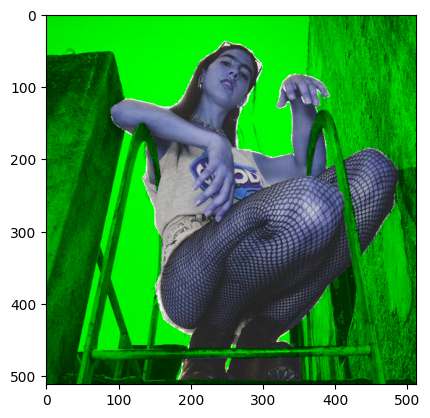

In [42]:
# sanity check
draw_masks(train_x[16], train_y[16])

In [43]:
lr = 3e-4
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  lr,
  decay_steps=5,
  decay_rate=0.02,
  staircase=False)
# initial epochs == 40
num_epochs = 26
model_path = os.path.join("files", "model.keras")
csv_path = os.path.join("files", "data.csv")

In [44]:
model = deeplabv3_plus((H, W, 3))
model.compile(loss=BinaryFocalCrossentropy(), optimizer=Adam(lr), metrics=[dice_coef, dice_loss, Recall(), Precision()], jit_compile=False)

In [45]:
print(model.metrics, model.metrics_names)

[<Mean name=loss>, <CompileMetrics name=compile_metrics>] ['loss', 'compile_metrics']


In [46]:
model_path

'files/model.keras'

In [47]:
if os.path.exists(model_path):
    try:
        from keras.models import load_model
        model = load_model(model_path)
    except Exception as e:
        print("НЕ МОГУ ЗАГРУЗИТЬ МОДЕЛЬ")

In [48]:
# If model plateau'es, we stop (minimum learning rate = 1 / 10 ** 7)
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=False, save_weights_only=False, save_freq='epoch'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

In [ ]:
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    class_weight={0:0.3, 1:0.7}
),

Epoch 1/26


2024-06-04 13:04:19.862624: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/spatial_dropout2d_22_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-04 13:04:24.062674: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


1193/1193 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - dice_coef: 0.8786 - dice_loss: -0.8786 - loss: 0.0070 - precision: 0.9503 - recall: 0.9848
Epoch 1: saving model to files/model.keras
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 513s 400ms/step - dice_coef: 0.8786 - dice_loss: -0.8786 - loss: 0.0070 - precision: 0.9503 - recall: 0.9848 - val_dice_coef: 0.8869 - val_dice_loss: -0.8869 - val_loss: 0.0451 - val_precision: 0.9212 - val_recall: 0.9649 - learning_rate: 2.9440e-04
Epoch 2/26
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - dice_coef: 0.9057 - dice_loss: -0.9057 - loss: 0.0047 - precision: 0.9652 - recall: 0.9896
Epoch 2: saving model to files/model.keras
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 474s 397ms/step - dice_coef: 0.9057 - dice_loss: -0.9057 - loss: 0.0047 - precision: 0.9652 - recall: 0.9896 - val_dice_coef: 0.8905 - val_dice_loss: -0.8905 - val_loss: 0.0451 - val_precision: 0.9256 - val_recall: 0.9654 - learning_rate: 2.9411e-04
Epoch 3/26
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - dice_co